In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from scipy import integrate as spi

In [2]:
from EqMotion import Integrator

integrator = Integrator()

In [3]:
def LFR(t):
    return 0.95 - (0.95-0.15) / 150.0 * t

def alpha3(t):
    return 9.8 + (60.0 - 9.8) * t / 150.0

def alpha2(t):
    return np.sin(t * 2 * np.pi / 3.0) * np.tanh(t/150.0)

def theta(t):
    return 0.0

def d2theta(t):
    return 0.0

In [7]:
t = np.linspace(0.0, 100.0, 1001)
y0 = np.zeros(6)

q, q_func = integrator.solve(y0, t, args=(alpha2, alpha3, theta, d2theta, LFR))

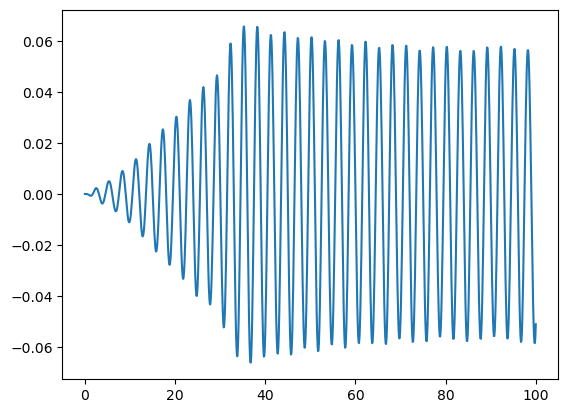

In [8]:
plt.plot(t, q[:, 0])

In [9]:
LFRt = LFR(t)
M_kt = integrator.M_k(LFRt)
L_kt = integrator.L_k(LFRt)
omega_kt = alpha3(t) / L_kt

In [10]:
omega_kt.shape

(3, 1001)

In [30]:
deg = 1
p = np.polyfit(LFRt, omega_kt.T, deg = deg)

In [31]:
p.T

array([[ -9.21364205,  17.11528447],
       [-46.4143599 ,  62.13885894],
       [-77.11732556, 101.09006699]])

In [32]:
np.flip(p.T, axis = 1)

array([[ 17.11528447,  -9.21364205],
       [ 62.13885894, -46.4143599 ],
       [101.09006699, -77.11732556]])

In [14]:
from EqMotion import Adjoint
adjoint = Adjoint({"Omega":np.flip(p.T, axis = 1), "H": None})
adjoint_ref = Adjoint({"Omega": np.array([[6.0],[20.0],[40.0]]), "H":None})

TypeError: Adjoint.__init__() missing 1 required positional argument: 'Np'

In [12]:
t = np.linspace(0.0, 10.0, 501)
q, q_func = adjoint_ref.forward(np.zeros(6), t, args=(alpha2, alpha3, 0.0, LFR))

In [13]:
x, x_func = adjoint.forward(np.zeros(6), t, args = (alpha2, alpha3, 0.0, LFR))

In [14]:
lam, lam_func = adjoint.backward(np.zeros(6), t, args = (x_func, q_func, LFR))

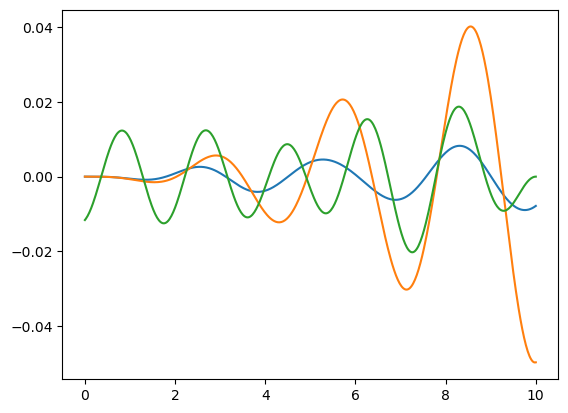

In [15]:
plt.plot(t, x[:, 0])
plt.plot(t, q[:, 0])
plt.plot(t, lam[:, 3])
# plt.ylim(-1e-3,1e-3)

In [16]:
dFdp = adjoint.grad(lam_func, x_func, LFR, workers = 1)

In [17]:
dFdp

(array([1.62192819e-04, 4.85234620e-07, 5.19565266e-08]),
 2.0243992841444602e-13)

In [19]:
lfr = LFR(t)
dFdp_ = adjoint.grad_simpson(lam.T, x.T, lfr)
dFdp_

array([1.62259485e-04, 4.85378513e-07, 5.19754498e-08])

In [30]:
F0 = adjoint.objFunc_simpson(x, q)

eps1 = np.array([[1e-3], [0.0], [0.0]])
adjoint1 = Adjoint({"Omega":np.flip(p.T, axis = 1)+ eps1, "H": None})
x1, x_func1 = adjoint1.forward(np.zeros(6), t, args = (alpha2, alpha3, 0.0, LFR))
F1 = adjoint1.objFunc_simpson(x1, q)

In [31]:
(F1 - F0)/1e-3

0.00016224558995999241

In [ ]:
solver = Adjoint({"Omega":np.flip(p.T, axis = 1), "H": None},
                  forward_args=(alpha2, alpha3, 0.0, LFR),
                  backward_args=)

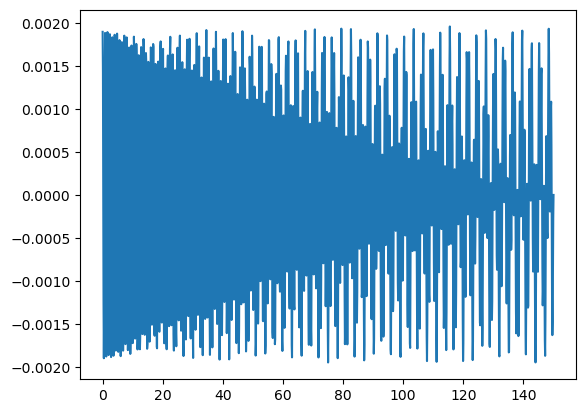

In [ ]:
# plt.plot(t, x[:, 0])
plt.plot(adjoint.T - t, lam[:, 2])
# plt.xlim(100, 120)

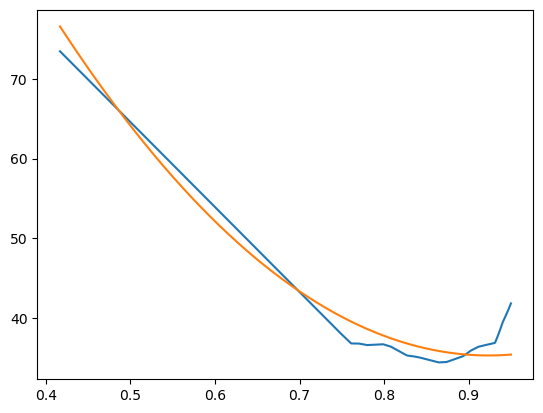

In [22]:
deg = 2
p = np.polyfit(LFRt, omega_kt.T, deg = deg)
omega_kt_fit = p.T @ np.array([LFRt**k for k in np.arange(deg, -1, -1)])
plt.plot(LFRt,     omega_kt[2, :])
plt.plot(LFRt, omega_kt_fit[2, :])

In [23]:
p

array([[  58.37431819,  109.41979599,  160.34197012],
       [ -88.99187692, -195.95474776, -296.25135138],
       [  42.98639313,  110.63298306,  172.15255919]])

In [ ]:
npoly = 4
a = np.random.rand(npoly)

poly = lambda x: a @ np.array([x**k for k in range(npoly)])